In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [28]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'retina'"""

import warnings

from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import pickle

from scipy.optimize import curve_fit


import statsmodels.formula.api as smf
from scipy.stats import zscore, pearsonr, spearmanr

from neurodsp.spectral import compute_spectrum
from fooof import FOOOF

""" import seaborn as sns
sns.set_style('whitegrid')"""

import matplotlib.pyplot as plt
#from matplotlib import cm, rc



### Read pickle files  - organoid foof results and metadata

In [3]:
#get pickle results in folder

pickle_org_metadata= '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/organoid_metadata_clean.pkl'
pickle_org_fooof  = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/workflow_run_fooof_2023-08-14_1423.pkl'


In [22]:
#load pickle files
with open(pickle_org_metadata, 'rb') as f:
    organoid_metadata_clean = pickle.load(f)
    
with open(pickle_org_fooof, 'rb') as f:
    wf = pickle.load(f)

In [25]:
knee_freq_range = (0.01,9.99)
zscore_thresh = 4
spec_type =  'Welch' # 'Welch' or 'AR_3'
spec_type_i = 0 # parallels spec_types to index the data
knee_no_2 = False # for summary plots, if single knee leave false, if double use false/true for knee 1/2

In [79]:
n_fits,n_spec_types = wf.results.shape
days = [organoid_metadata_clean['day_postdiff'].iloc[i] for i in range(n_fits)]
if knee_no_2:
    taus = [wf.results[i][spec_type_i].tau_double for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq_double for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]
else:
    taus = [wf.results[i][spec_type_i].tau for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]

unique_recordings = np.unique(organoid_metadata_clean['day_postdiff'])
unique_wells = np.unique(organoid_metadata_clean['well'].values)
unique_channels = np.unique(organoid_metadata_clean['channel'])
n_recordings = len(unique_recordings); n_wells = len(unique_wells); n_channels = len(unique_channels)
compiled_data_taus = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_knee_freqs = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_days = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_rsqs = np.full((n_recordings,n_wells,n_channels),np.nan)
for rec_i,recording in enumerate(unique_recordings):
    for well_i,well in enumerate(unique_wells):
        for channel_i,channel in enumerate(unique_channels):
            this_idx_np = np.where((organoid_metadata_clean['day_postdiff'] == recording) & (organoid_metadata_clean['well'].values == well) & (organoid_metadata_clean['channel'].values == channel))[0]
            if np.size(this_idx_np) > 0:
                if len(this_idx_np) > 1:
                    breakme
                this_idx = this_idx_np[0]
                compiled_data_taus[rec_i,well_i,channel_i] = taus[this_idx]
                compiled_data_knee_freqs[rec_i,well_i,channel_i] = knee_freqs[this_idx]
                compiled_data_days[rec_i,well_i,channel_i] = days[this_idx]
                compiled_data_rsqs[rec_i,well_i,channel_i] = rsqs[this_idx]

knee_freq_mask = (compiled_data_knee_freqs < knee_freq_range[0]) | (compiled_data_knee_freqs > knee_freq_range[1])
compiled_data_taus_kfm = np.copy(compiled_data_taus); compiled_data_taus_kfm[knee_freq_mask] = np.nan
compiled_data_knee_freqs_kfm = np.copy(compiled_data_knee_freqs); compiled_data_knee_freqs_kfm[knee_freq_mask] = np.nan
compiled_data_days_kfm = np.copy(compiled_data_days); compiled_data_days_kfm[knee_freq_mask] = np.nan
compiled_data_rsqs_kfm = np.copy(compiled_data_rsqs); compiled_data_rsqs_kfm[knee_freq_mask] = np.nan

rsq_mask = compiled_data_rsqs < 0.9
compiled_data_taus_kfm_rsq = np.copy(compiled_data_taus_kfm); compiled_data_taus_kfm_rsq[rsq_mask] = np.nan
compiled_data_rsqs_kfm_rsq = np.copy(compiled_data_rsqs_kfm); compiled_data_rsqs_kfm_rsq[rsq_mask] = np.nan

dims_compiled = compiled_data_taus_kfm_rsq.shape
compiled_data_taus_kfm_rsq_vec = np.reshape(compiled_data_taus_kfm_rsq, (dims_compiled[0], np.product(dims_compiled[1:])))

compiled_data_taus_kfm_rsq_vec[np.abs(zscore(compiled_data_taus_kfm_rsq_vec,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan

In [82]:
days_in = compiled_data_days_kfm.ravel()
data_in = np.log10(compiled_data_taus_kfm_rsq_vec.ravel())



# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
days_np = np.array(days_in)
days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)

mask = [t >= 0.2 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])





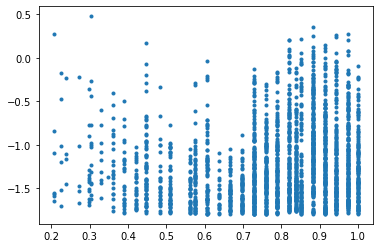

In [83]:
plt.plot(days_in, data_in, '.')

## Hypotheses fitting (for figure 2 for timescale dev paper)

In [84]:
def rsq(xdata, ydata, popt, f):
    
    #residual sum of squares
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared
    

In [114]:
def f_test(xdata, ydata, model0, model1, popt0, popt1, p0, p1):

    yfit0 = model0(xdata, *popt0)
    yfit1 = model1(xdata, *popt1)

    ssq0 = ((yfit0-ydata)**2).sum()
    ssq1 = ((yfit1-ydata)**2).sum()
    
    param_diff = p1 - p0
    print(param_diff)
    
    if param_diff == 0:
        df_0 = len(xdata) - p0
        print("df0",df_0)
        df_1 = len(xdata) - p1
        print("df1", df_1)
        f_ratio = ssq1/ssq0
        p = 1 - ss.f.cdf(f_ratio, df_0, df_1)
    else:
        df = len(xdata) - p1
        print("df", df)
        f_ratio = ((ssq0 - ssq1) / param_diff) / (ssq1 / df)
        p = 1 - ss.f.cdf(f_ratio, param_diff, df)

    return f_ratio, p

In [99]:
# Define the Gaussian function
def gaussian(x,a,x0,sigma, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))  + c
# Define the sigmoid function
def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-C * (x - B))) + D

# Define the horizontal line function (constant)
def horizontal_line(x, A):
    return A

In [87]:
def fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid):
    
    
    # Fit the Gaussian function to your data
    params_gaussian, _ = curve_fit(gaussian, divs, taus, p0=guess_gaussian, bounds=bounds_gaussian, maxfev=2000)

    # Fit the sigmoid function to your data
    params_sigmoid, _ = curve_fit(sigmoid, divs, taus, p0=guess_sigmoid,method='dogbox', maxfev=2000)

    # Fit the horizontal line to your data
    params_horizontal_line, _ = curve_fit(horizontal_line, divs, taus)


    return params_horizontal_line, params_sigmoid, params_gaussian

In [88]:
def plt_hyp(divs, taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None ):
    
    # Create a range of x values for plotting
    x_fit = np.linspace(min(divs), max(divs), 100)

    # Calculate the corresponding y values using the fitted parameters for each function
    y_fit_gaussian = gaussian(x_fit, *params_gaussian)
    y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
    y_fit_horizontal_line = horizontal_line(x_fit, params_horizontal_line[0])

    # Plot the data and the fitted functions
    plt.figure(figsize =  (6,5))
    # Create the scatter plot of the data
    plt.plot(divs, taus, '.', color = "dimgrey")
    #plt.ylabel("Log(timescales)", size = 18)
    #plt.xlabel("Days ", size = 18)
    plt.xticks(size = 13)
    plt.yticks(size = 13)

    plt.axhline(y=params_horizontal_line[0], xmin = 0.04, xmax = 0.98, color='#FDAE61', linestyle='-.', linewidth=5,dashes=(5,2))
    plt.plot(x_fit, y_fit_sigmoid, '-.', color='#2D7BB6', linewidth=5, dashes=(4,2))
    plt.plot(x_fit, y_fit_gaussian, '-.',color='#D7191D', linewidth=5, dashes=(2, 2))
    
    if ylim:
        plt.ylim(ylim[0],ylim[1])

    
    """
    days_pn = ['6', '11', '16', '21','26','31']
    
    locs, labels = plt.xticks()
    print(locs)
    labels = days_pn
    plt.xticks(locs[1:-1], labels)"""
    plt.show()

### Log version

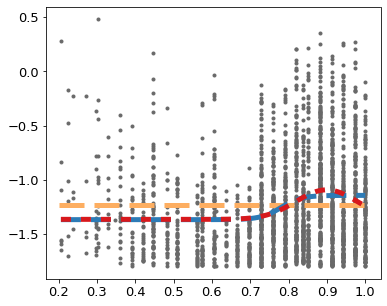

In [100]:
# guesses
guess_sigmoid = [
    0.3, # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    -1.4 # offset
]
guess_gaussian = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]

bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

#fit_method = 'trf' # 'lm', 'trf', 'dogbox'
params_horizontal_line, params_sigmoid, params_gaussian = fit_hyp(days_in, data_in, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days_in, data_in, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None )


### Compute rsqs for fits - log version

In [101]:
#get r-squared values

rsqs_rat_h0 = rsq(days_in,  data_in, params_horizontal_line, horizontal_line) 
rsqs_rat_h1 = rsq(days_in,  data_in, params_sigmoid, sigmoid) 
rsqs_rat_h2 = rsq(days_in,  data_in, params_gaussian, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.045134394541365475
rsq rat h2: 0.0512061495133832


### f-tests

In [115]:

#f-tests
f_test_h0_h1 = f_test(days_in, data_in, horizontal_line, sigmoid,
                      params_horizontal_line, params_sigmoid, 1, 4)
f_test_h0_h2 = f_test(days_in, data_in, horizontal_line, gaussian, 
                      params_horizontal_line, params_gaussian,1,4)
f_test_h2_h1 = f_test(days_in, data_in, gaussian, sigmoid, 
                      params_gaussian, params_sigmoid,4,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

3
df 2367
3
df 2367
0
df0 2367
df1 2367
f_test rat h0 vs h1: (37.29429260993528, 1.1102230246251565e-16)
f_test rat h0 vs h2: (42.582118281371834, 1.1102230246251565e-16)
f_test rat h1 vs h2: (1.0063994459585754, 0.4383476514623941)


## Mean analysis

### Get mean days and timescales

In [103]:
def get_mean_std_recday (taus, divs):
    days = sorted(set(divs))
    all_indices = []
    days_taus = []
    mean_taus = []
    std_taus = []

    #get indices for each day

    for d in days:
   
        indices = [i for i, x in enumerate(divs) if x == d]

        
        all_indices.append(indices)
        #get taus for those indices
        day_taus = taus[indices]
        days_taus.append(day_taus)
        #get means and stds
        mean_taus.append(np.mean(day_taus))
        std_taus.append(np.std(day_taus))
        
    return [days, all_indices, days_taus, mean_taus, std_taus]

In [104]:
days, all_indices,days_taus_filt, mean_taus_filt, std_filt = get_mean_std_recday(data_in, days_in)

Text(0.5, 1.0, 'Mean day taus')

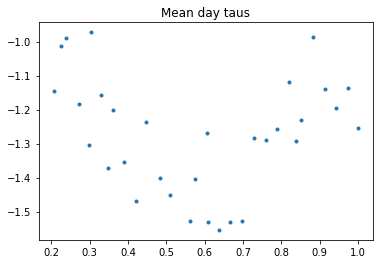

In [105]:
#plot the mean
plt.plot(days, mean_taus_filt, '.')
plt.title("Mean day taus")

### Fit the mean 

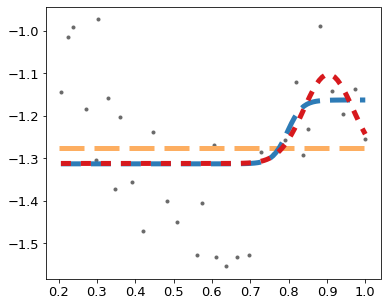

In [106]:
#Linear

# Guess and bounds for Gaussian fit
# guesses
guess_sigmoid = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_gaussian = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]

bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean = fit_hyp(days, mean_taus_filt, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days,  mean_taus_filt, params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean, ylim=None )


### Calculate rsq for mean

In [109]:
#get r-squared values

rsqs_rat_h0 = rsq(days,  mean_taus_filt,params_horizontal_line_mean, horizontal_line) 
rsqs_rat_h1 = rsq(days,  mean_taus_filt,  params_sigmoid_mean, sigmoid) 
rsqs_rat_h2 = rsq(days,  mean_taus_filt, params_gaussian_mean, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.13503763922065937
rsq rat h2: 0.15022234506734944


### f-tests for mean

In [111]:

#f-tests
f_test_h0_h1 = f_test(days, mean_taus_filt, horizontal_line, sigmoid,
                      params_horizontal_line_mean, params_sigmoid_mean, 1, 4)
f_test_h0_h2 = f_test(days, mean_taus_filt, horizontal_line, gaussian, 
                      params_horizontal_line_mean, params_gaussian_mean,1,4)
f_test_h2_h1 = f_test(days, mean_taus_filt, gaussian, sigmoid, 
                      params_gaussian_mean, params_sigmoid_mean,4,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

f_test rat h0 vs h1: (1.4571169296398405, 0.2475034633207953)
f_test rat h0 vs h2: (1.6499318527500189, 0.20039489634531682)
f_test rat h1 vs h2: (1.0178690340450214, 0.4814786425240152)
